In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import sys
import seaborn as sns
from matplotlib import cm
import scipy
from sklearn.model_selection import KFold
from scipy.stats import betabinom
import copy
import itertools

## Read epitope data

In [3]:
## Read epitope data
# path_to_epitope_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/eptope_data_MHCII.csv"
path_to_epitope_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/MHCI/epitope_data_MHCI.csv"
epitope_raw_df = pd.read_csv(path_to_epitope_file,skiprows=1)
epitope_raw_df = epitope_raw_df[['Epitope ID',"Description","Antigen Name"]]
## Read experiment data
# path_to_experiment_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/experiment_data_MHCII.csv"
path_to_experiment_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/MHCI/experiment_data_MHCI.csv"
experiment_raw_df = pd.read_csv(path_to_experiment_file,skiprows=1)
experiment_raw_df = experiment_raw_df[['Epitope ID',"Cell Type","Allele Name","Antigen Description","Qualitative Measure","Assay Group","Number of Subjects Tested","Number of Subjects Responded"]].dropna()
experiment_raw_df.sort_values(by='Epitope ID', ascending=True)

/var/folders/px/wpqhk62d559gjgm0ql254vq00000gn/T/ipykernel_81272/1737443017.py:9: DtypeWarning: Columns (5,14,22,23,24,27,28,29,30,31,32,35,36,38,39,45,46,47,48,52,53,54,55,56,57,61,62,63,64,65,67,68,69,70,71,72,73,74,75,76,77,78,81,82,83,86,88,96,97,116) have mixed types. Specify dtype option on import or set low_memory=False.
  experiment_raw_df = pd.read_csv(path_to_experiment_file,skiprows=1)


,Epitope ID,Cell Type,Allele Name,Antigen Description,Qualitative Measure,Assay Group,Number of Subjects Tested,Number of Subjects Responded
188,10,T cell CD8+,HLA-B*51:01,AAAAAIFVI,Positive,IFNg release,14.0,4.0
93,10,T cell CD8+,HLA-B*51:01,AAAAAIFVI,Positive,cytotoxicity,3.0,3.0
41368,10,T cell CD8+,HLA-B*51:01,AAAAAIFVI,Negative,IFNg release,15.0,0.0
41369,10,T cell CD8+,HLA-B*51:01,MHC class I related protein A,Positive,IFNg release,3.0,3.0
1782,39,T cell CD8+,HLA class I,AAAIFMTATPPGTAD,Negative,IFNg release,15.0,0.0
...,...,...,...,...,...,...,...,...
76822,1707900,T cell CD8+,HLA-A*02:01,WLTYTGAIKL,Positive,IFNg release,3.0,1.0
77001,1709065,T cell CD8+,HLA-A*24:02,YFNKKDWYDF,Negative,IFNg release,3.0,0.0
76791,1709453,T cell CD8+,HLA-A*02:06,YIIKLIFLWL,Negative,IFNg release,3.0,0.0
76812,1711481,T cell CD8+,HLA-A*33:03,YYKLGASQR,Positive,IFNg release,3.0,1.0


## Adding tested subjects from different experiments into the same df

In [4]:
filter_lengths = [9,10]
epitope_raw_df["epitope_length"] = epitope_raw_df["Description"].apply(lambda x: len(x.strip()))
epitope_df = epitope_raw_df[epitope_raw_df.epitope_length.isin(filter_lengths)]
epitope_df.head()

,Epitope ID,Description,Antigen Name,epitope_length
0,10,AAAAAIFVI,MHC class I related protein A,9
2,44,AAALALHFL,Tegument protein UL25,9
6,73,AACIVGCENV,cysteine proteinase cruzipain (EC 3.4.22.-) - ...,10
11,130,AAFDRKSDAK,Epstein-Barr nuclear antigen 4,10
13,140,AAFSSARFL,Accessory protein p30II,9


## Analyse dataset - Which assay groups are found do they correlate?

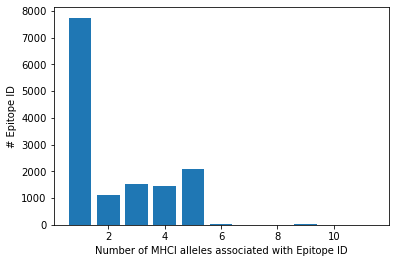

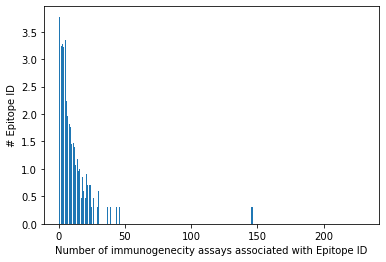

In [8]:
epitope_IDS = epitope_df["Epitope ID"]
unique_alleles = []
unique_assays = []
experiment_scores = dict()

for ID in epitope_IDS:
    if len(experiment_raw_df[experiment_raw_df["Epitope ID"] == ID]) == 0:
        continue

    number_of_assay_groups_for_id = len(experiment_raw_df[experiment_raw_df["Epitope ID"] == ID]["Assay Group"])
    number_of_HLA_alleles = len(set(experiment_raw_df[experiment_raw_df["Epitope ID"] == ID]["Allele Name"]))
    unique_alleles.append(number_of_HLA_alleles)
    unique_assays.append(number_of_assay_groups_for_id)

    if number_of_assay_groups_for_id  == 0 :
        print(experiment_raw_df[experiment_raw_df["Epitope ID"] == ID])



    peptide = list(epitope_df[epitope_df["Epitope ID"] == ID]["Description"])[0]
    experiments_with_peptide = experiment_raw_df[experiment_raw_df["Epitope ID"] == ID]
    
    
    for i,experiment in experiments_with_peptide.iterrows():
        if experiment["Antigen Description"] == peptide:
            unique_identifier = peptide + "_" + experiment["Allele Name"]
            
            if unique_identifier not in experiment_scores.keys():
                experiment_scores[unique_identifier] = dict()
            
            assay = experiment["Assay Group"]
            tested_subjects = experiment["Number of Subjects Tested"]
            positive_subjects = experiment["Number of Subjects Responded"]
            N = tested_subjects
            m = positive_subjects
            a = 1 + m
            b = 1 + N - m
            score = betabinom.mean(1,a, b)
            
            if assay not in experiment_scores[unique_identifier].keys():
                experiment_scores[unique_identifier][assay] = [score]
            else:
                experiment_scores[unique_identifier][assay].append(score)


unique_alleles, counts= np.unique(unique_alleles,return_counts=True)
plt.bar(unique_alleles,counts)
plt.xlabel("Number of MHCI alleles associated with Epitope ID")
plt.ylabel("# Epitope ID")
plt.show()

unique_assays, counts= np.unique(unique_assays,return_counts=True)
plt.bar(unique_assays,np.log10(counts))
plt.xlabel("Number of immunogenecity assays associated with Epitope ID")
plt.ylabel("# Epitope ID")
plt.show()

## Count of assays occurences

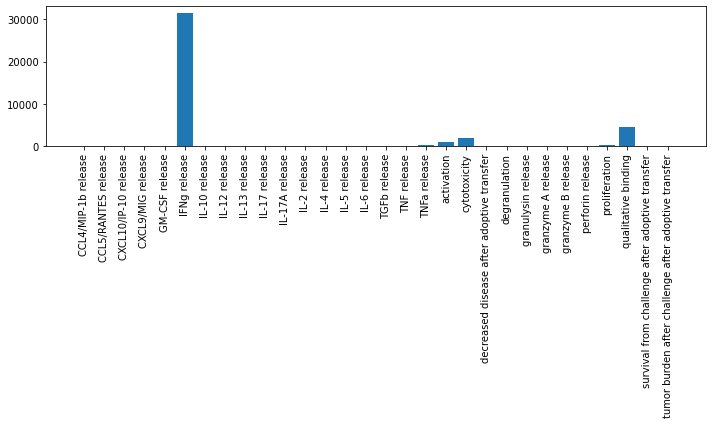

In [9]:
epitope_IDS = epitope_df["Epitope ID"]
experiments = experiment_raw_df[experiment_raw_df["Epitope ID"].isin(epitope_IDS)]["Assay Group"].to_numpy()
unique_experiments,counts = np.unique(experiments,return_counts=True)

experiment_counter = {x:y for x,y in zip(unique_experiments,counts)}

most_common_experiments = sorted(experiment_counter.keys(),key=lambda x: experiment_counter[x],reverse=True)
fig = plt.figure(figsize=(10,6))
plt.bar(np.arange(len(unique_experiments)),counts)
plt.xticks(np.arange(len(unique_experiments)),unique_experiments,rotation=90)
plt.tight_layout()
plt.show()

## Correlation between immunogenecity scores

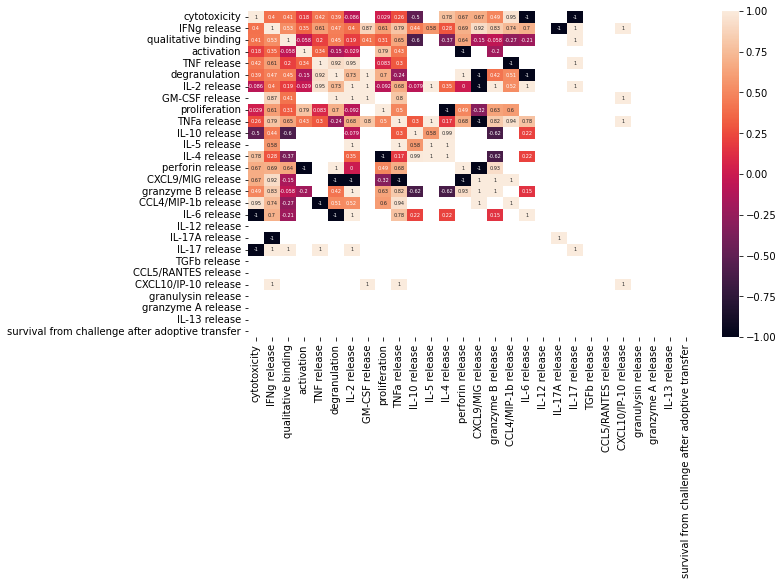

In [10]:
assay_correlation_dict = copy.deepcopy(experiment_scores)
for peptide_HLA in assay_correlation_dict.keys():
    for assay in assay_correlation_dict[peptide_HLA].keys():
        assay_correlation_dict[peptide_HLA][assay] = np.mean(assay_correlation_dict[peptide_HLA][assay])

assay_correlation_df = pd.DataFrame.from_dict(assay_correlation_dict).T
fig = plt.figure(figsize=(10,6))
corr = assay_correlation_df.corr(method="spearman")
sns.heatmap(corr,annot=True,annot_kws={"fontsize":5})
plt.show()


## Standard deviation of immunogenecity scores

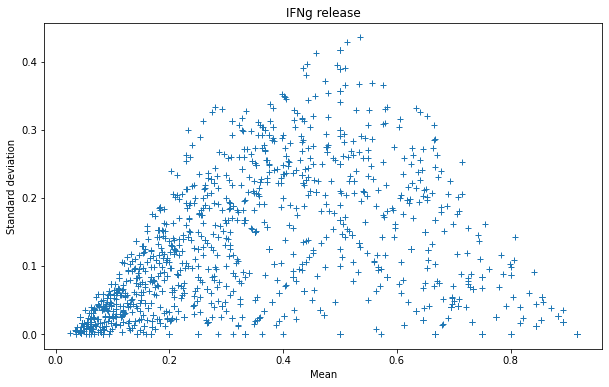

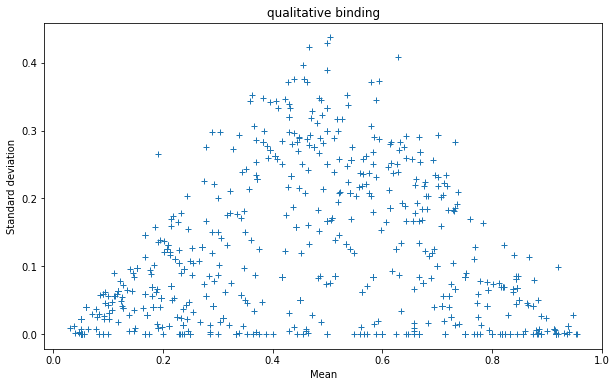

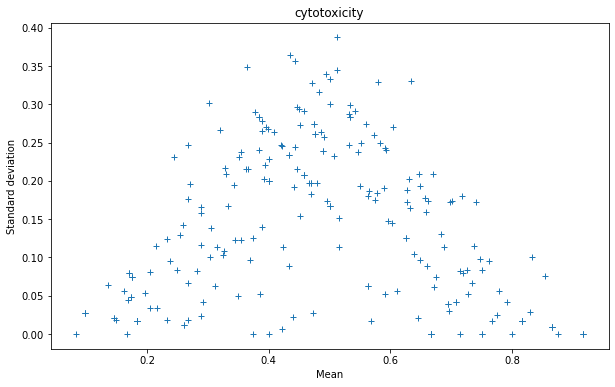

In [12]:
for assay in most_common_experiments[:3]:
    means = []
    stds = []
    number_of_assays = []
    for peptide in experiment_scores.keys():
        try:
            if len(experiment_scores[peptide][assay]) > 1:
                number_of_assays.append(len(experiment_scores[peptide][assay]))
                mean, std = np.mean(experiment_scores[peptide][assay]), np.std(experiment_scores[peptide][assay])
                means.append(mean)
                stds.append(std)
        except KeyError:
            continue


    plt.figure(figsize=(10,6))
    plt.title(assay)
    plt.plot(means,stds,"+")
    plt.xlabel("Mean")
    plt.ylabel("Standard deviation")
    plt.show()

    # unique_assays, counts= np.unique(np.array(number_of_assays),return_counts=True)
    # plt.bar(unique_assays[:10],counts[:10])
    # plt.show()

